In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cuqi
from scipy import sparse
from besov_prior import besov_prior

Our problem is as follows:
Ax=y where A is the convolution.
We are working on a periodic boundary and our kernal is Gaussian.
 

ProblemInfo with the following set attributes:
['infoString', 'exactSolution', 'exactData']
 infoString: Noise type: Additive Gaussian with std: 0.05


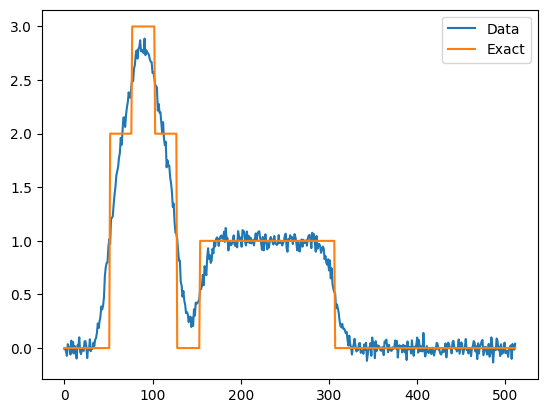

In [2]:
J = 9
n = 2**J
std = 0.05
model1, data1, probInfo1 = cuqi.testproblem.Deconvolution1D.get_components(dim=n,noise_std=std,phantom='pc')
print(probInfo1)
plt.figure()
plt.plot(data1, label='Data')
plt.plot(probInfo1.exactSolution,label='Exact')
plt.legend()

As we see in the above figure: the blue curve is our noisy data and the orange curve is the exact solution.

Our Method:
Our prior has the Besov probablity density:
$\Pi_{Besov} \propto exp(-\frac{\gamma}{p} ||Bx||_p^p)$
 where $Bx \approx \{2^{j(s+\frac{d}{2}-frac{d}{p})} <\Xi_{func}, \psi_{j,k}>\}$
where $\gamma,$ p, s are our parameters and $d$ is the dimension.

In [3]:
s = 1
p = 1.5
wavelet = 'db1'
gamma = 10
prior = besov_prior(J,gamma,0,s,p,wavelet)
B_T = sparse.csr_matrix(np.transpose(prior.compute_besov_matrix()))
logpdf = lambda x:-gamma/p*np.linalg.norm(prior.wavelet_weigth(x),ord=p)**p
gradient = lambda x:-gamma*B_T@(np.sign(prior.wavelet_weigth(x))*np.abs(prior.wavelet_weigth(x))**(p-1))
x=cuqi.distribution.UserDefinedDistribution(dim=n, logpdf_func=logpdf, gradient_func=gradient)

Posterior
    Equation:
	 p(x|y) ∝ L(x|y)p(x)
  
	y ~ CUQI Gaussian Likelihood function. Parameters ['x'].

$$ y \sim N(A, std^2)$$

In [4]:
y = cuqi.distribution.Gaussian(model1(x),std**2)
joint = cuqi.distribution.JointDistribution(y,x)
posterior = joint(y=data1)

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic solver selection is experimental. !!!
!!!    Always validate the computed results.    !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Optimizing with exact gradients
Using scipy.optimize.minimize on negative log of Posterior
x0: ones vector


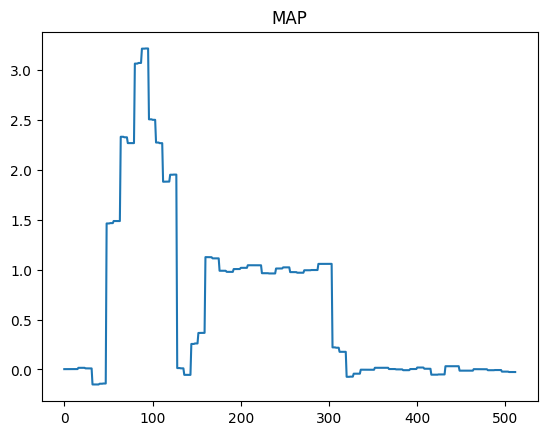

In [5]:
BP = cuqi.problem.BayesianProblem(y, x).set_data(y=data1)
MAP = BP.MAP(disp=True,x0=np.ones((n)))
plt.figure()
plt.plot(MAP)
plt.title('MAP')
plt.show()

In [6]:
sampler = cuqi.sampler.NUTS(posterior)
samples = sampler.sample_adapt(1000,300)

Sample 1300 / 1300


In [7]:
final_samples = samples.burnthin(0,2)

Selecting 5 randomly chosen variables


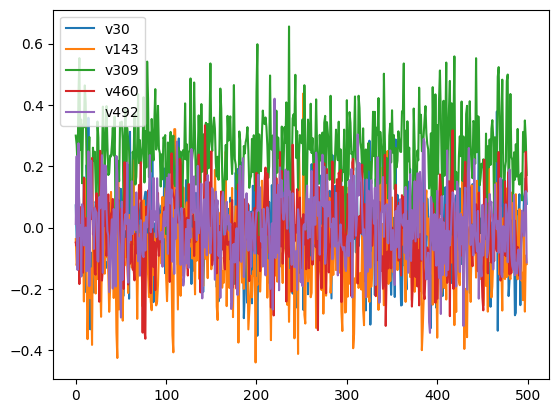

In [8]:
final_samples.plot_chain()

Selecting 5 randomly chosen variables


array([[<Axes: title={'center': 'v251'}>,
        <Axes: title={'center': 'v319'}>,
        <Axes: title={'center': 'v405'}>],
       [<Axes: title={'center': 'v468'}>,
        <Axes: title={'center': 'v501'}>, <Axes: >]], dtype=object)

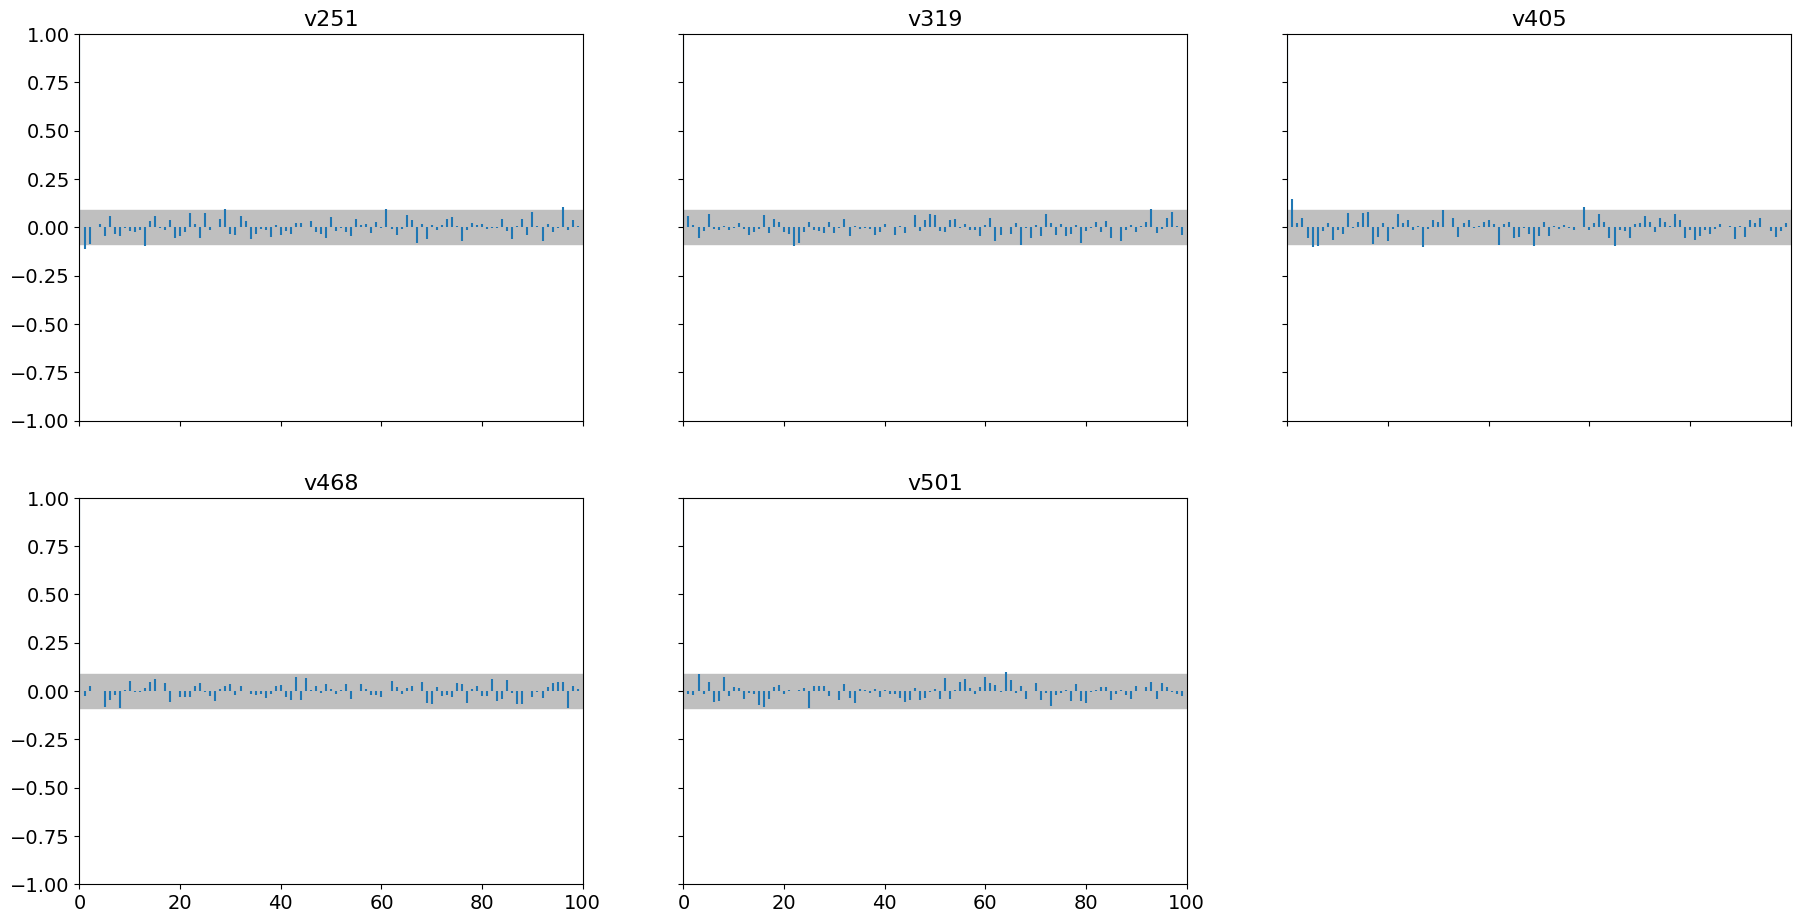

In [9]:
final_samples.plot_autocorrelation()

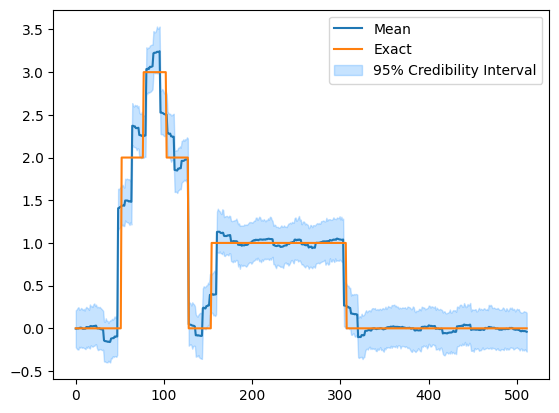

In [10]:
final_samples.plot_ci(95,exact=probInfo1.exactSolution)